In [1]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")

In [3]:
def cannotconvert(mydata):
    try :
        float(mydata)
        return False
    except ValueError:
        return True
#create the indeces array here

#indx = np.zeros(len(nrg['Site EUI(kBtu/ft2)']))
indx = []
indx1 = []
for k,v in enumerate(nrg['Site EUI(kBtu/ft2)']):
    indx.append(cannotconvert(v))
    
for k,v in enumerate(nrg['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)']):
    indx1.append(cannotconvert(v))

    
#nrg['convert_EUI'] = nrg['Site EUI(kBtu/ft2)'][canconvert(nrg['Site EUI(kBtu/ft2)'])]
nrg['Site EUI(kBtu/ft2)'][indx]='NaN'

##etc etc... for all columns you care about
nrg['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'][indx1]= 'NaN'



/Users/mading/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mading/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg, bsize, on = 'BBL')

bblnrgdata.dropna(how = 'any', subset=['Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'])
bblnrgdata = bblnrgdata[bblnrgdata['Site EUI(kBtu/ft2)'] != nan]
print bblnrgdata['Site EUI(kBtu/ft2)']
print bblnrgdata['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)']

bblnrgdata['energy'] = bblnrgdata['Site EUI(kBtu/ft2)'].astype(float) *\
      bblnrgdata['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'].astype(float)
bblnrgdata['log_energy'] = np.log10(bblnrgdata['energy'])
bblnrgdata['log_unitstotal'] = np.log10(bblnrgdata['UnitsTotal'])

print bblnrgdata['log_energy']



/Users/mading/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1840: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/Users/mading/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1116: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


0                     82.1
1       137.69999999999999
2                    103.2
3                       74
4                      130
5       138.30000000000001
6                    56909
7                     88.2
8                     15.7
9                      NaN
10                    85.7
11                   195.7
12      79.099999999999994
13                   144.1
14                   200.9
15                   104.6
16                    86.7
17                   102.1
18                    21.2
19                    78.3
20                     NaN
21                    55.2
22                    83.2
23                   145.1
24                    59.4
25                    82.7
26                   105.3
27                     NaN
28      132.69999999999999
29                     NaN
               ...        
6515                   NaN
6516                   NaN
6517                   NaN
6518                   NaN
6519                   NaN
6520                   NaN
6

/Users/mading/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1692: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))


In [6]:
bblnrgdata_clean=bblnrgdata[(bblnrgdata.energy>1000) & (bblnrgdata.energy<1e11) & (bblnrgdata.UnitsTotal>10) \
                            & (bblnrgdata.UnitsTotal<1000)]


In [7]:
mod = smf.ols(formula='log_energy ~ log_unitstotal', data = bblnrgdata_clean, missing = 'drop').fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:             log_energy   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     855.4
Date:                Sun, 22 Nov 2015   Prob (F-statistic):          2.32e-171
Time:                        22:52:25   Log-Likelihood:                -2505.7
No. Observations:                4216   AIC:                             5015.
Df Residuals:                    4214   BIC:                             5028.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.0738      0.033    181.

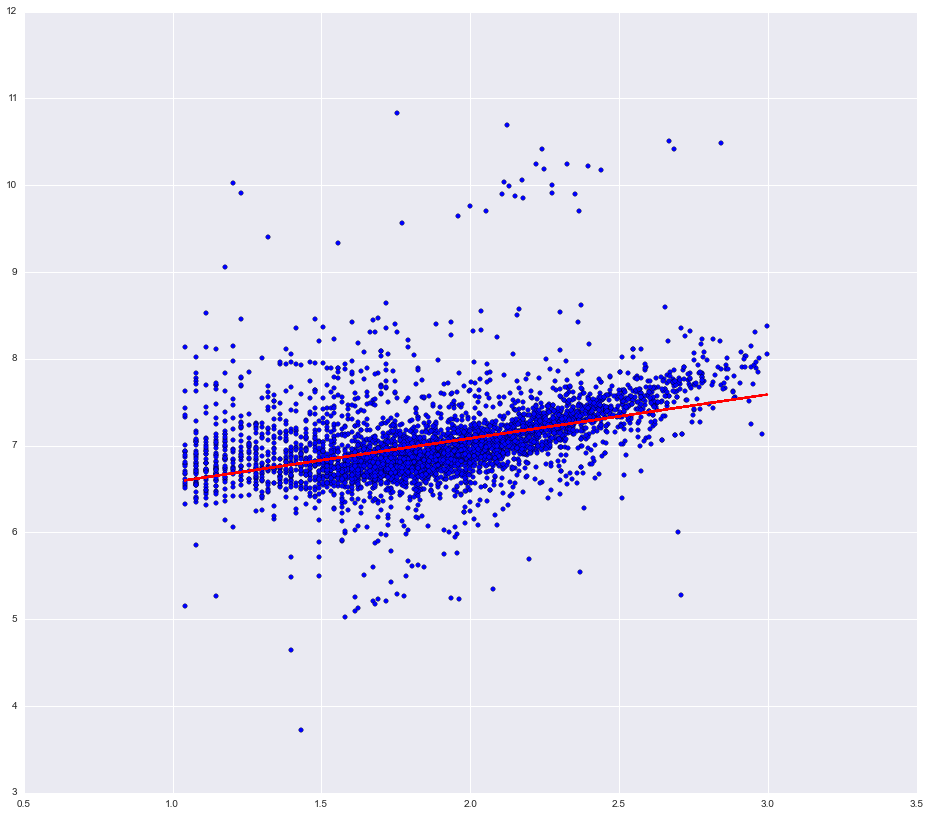

In [8]:
pl.figure(figsize=(16,14))
pl.scatter(bblnrgdata_clean.log_unitstotal,bblnrgdata_clean.log_energy)
plot(bblnrgdata_clean.log_unitstotal, mod.predict(),'r')

/Users/mading/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


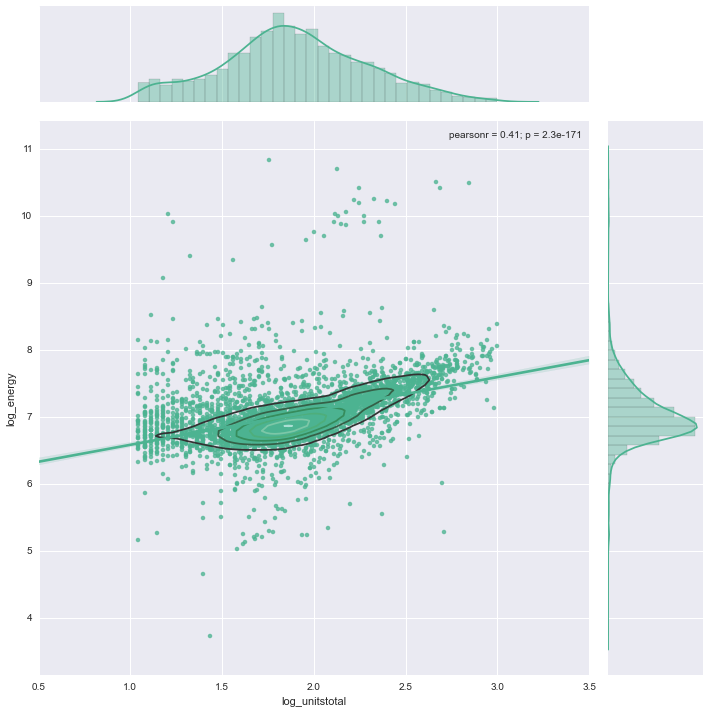

In [9]:
sns.set(style="darkgrid", color_codes=True)

g = (sns.jointplot("log_unitstotal", "log_energy", data = bblnrgdata_clean, kind="reg",\
                   color="#4CB391",  size=10).plot_joint(sns.kdeplot, zorder=1, n_levels=6))